# Análisis de Soluciones - VERSIÓN CORREGIDA

Este notebook analiza las soluciones con todos los bugs corregidos.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Configuración

In [65]:
# AJUSTA ESTAS RUTAS SEGÚN TU CASO
DATA_PATH = "../../data/INF-285"
SOLUTION_PATH = "../../results/solutions/data_INF-285/2025-11-24-231157"

data_path = Path(DATA_PATH)
solution_path = Path(SOLUTION_PATH)

# Cargar configuración
with open(solution_path / "configurations.txt", "r") as f:
    config = f.read()
    print("Configuración del algoritmo:")
    print(config)

Configuración del algoritmo:
Initial temperature: 100000.0
Final temperature: 50.0
Alpha: 0.95
Maximun iterations: 100000



## 2. Funciones de Carga y Penalización

In [66]:
def load_solution(csv_path):
    """Carga una solución desde un archivo CSV"""
    with open(csv_path, "r") as f:
        lines = f.readlines()

    solution = []
    for line in lines:
        if line.strip():
            row = line.strip().split()
            solution.append(row)

    return np.array(solution)


def load_students_data(data_path):
    """Carga los datos de disponibilidad de todos los estudiantes"""
    students_path = data_path / "students"
    students_files = sorted(students_path.glob("*.csv"), key=lambda x: int(x.stem))

    students_data = []
    for student_file in students_files:
        student_schedule = pd.read_csv(student_file, header=None).values
        students_data.append(student_schedule)

    num_slots, num_days = students_data[0].shape
    num_students = len(students_data)

    students_array = np.zeros((num_slots, num_days, num_students), dtype=int)
    for i, student_schedule in enumerate(students_data):
        students_array[:, :, i] = student_schedule

    return students_array, num_students

In [67]:
def penalty_free_day(students_data, student, day):
    """Penalización por día libre"""
    num_slots = students_data.shape[0]
    for slot in range(num_slots):
        if students_data[slot, day, student] == 1:
            return 0
    return 0.5


def penalty_slot(slot):
    """Penalización por slot"""
    if slot == 0 or slot == 8 or slot == 9:
        return 0.4
    elif slot == 7:
        return 0.3
    else:
        return 0


def penalty_windows(students_data, slot_, day, student):
    """Penalización por ventanas"""
    num_slots = students_data.shape[0]
    total_windows = 0
    window_l = 0
    window_m = 0
    found_assignment = False

    for slot in range(num_slots):
        if slot_ == slot:
            found_assignment = True
            if window_l == slot_:
                continue
            else:
                total_windows = window_l
        elif found_assignment:
            if students_data[slot, day, student] == 1:
                total_windows += window_m
                break
            else:
                window_m += 1
        else:
            if students_data[slot, day, student] == 1:
                window_l = 0
            else:
                window_l += 1

    return total_windows / 6


def penalty_slot2(students_data, slot, day, student):
    left = slot - 1 >= 0 and students_data[slot - 1, day, student] == 2
    right = (
        slot + 1 < students_data.shape[0] and students_data[slot + 1, day, student] == 2
    )
    return 0.5 if (left or right) else 0

In [68]:
def analyze_solution_FIXED(solution, students_data):
    """Analiza una solución - VERSIÓN CORREGIDA"""
    num_slots, num_days, num_students = students_data.shape

    assistantships = []
    for slot in range(num_slots):
        for day in range(num_days):
            if solution[slot, day] != "·":
                assistant = int(solution[slot, day])
                assistantships.append((slot, day, assistant))

    print(f"Ayudantías encontradas: {assistantships}")

    assistant_assignments = defaultdict(list)
    student_metrics = []
    students_can_attend = 0
    total_fitness = 0

    for student in range(num_students):
        best_fitness = float("-inf")
        best_slot = None
        best_day = None
        best_assistant = None
        best_penalties = {}

        for slot, day, assistant in assistantships:
            if students_data[slot, day, student] == 0:
                p_free_day = penalty_free_day(students_data, student, day)
                p_slot = penalty_slot(slot)
                p_windows = penalty_windows(students_data, slot, day, student)
                p_2 = penalty_slot2(students_data, slot, day, student)

                total_penalty = p_free_day + p_slot + p_windows + p_2
                fitness = 1 - total_penalty

                if fitness > best_fitness:
                    best_fitness = fitness
                    best_slot = slot
                    best_day = day
                    best_assistant = assistant
                    best_penalties = {
                        "penalty_free_day": p_free_day,
                        "penalty_slot": p_slot,
                        "penalty_windows": p_windows,
                        "penalty_total": total_penalty,
                        "penalty_slot2": p_2,
                    }

        if best_fitness != float("-inf"):
            students_can_attend += 1
            total_fitness += best_fitness
            assistant_assignments[best_assistant].append(student)

            student_metrics.append(
                {
                    "student": student,
                    "can_attend": True,
                    "slot": best_slot,
                    "day": best_day,
                    "assistant": best_assistant,
                    "fitness": best_fitness,
                    **best_penalties,
                }
            )
        else:
            student_metrics.append(
                {
                    "student": student,
                    "can_attend": False,
                    "slot": None,
                    "day": None,
                    "assistant": None,
                    "fitness": 0,
                    "penalty_free_day": 0,
                    "penalty_slot": 0,
                    "penalty_windows": 0,
                    "penalty_total": 0,
                    "penalty_slot2": 0,
                }
            )

    return {
        "student_metrics": pd.DataFrame(student_metrics),
        "assistant_assignments": dict(assistant_assignments),
        "total_fitness": total_fitness,
        "students_can_attend": students_can_attend,
        "attendance_percentage": (students_can_attend * 100) / num_students,
        "assignments": assistantships,
    }

## 3. Cargar Datos

In [69]:
students_data, num_students = load_students_data(data_path)
print(
    f"Datos: {students_data.shape[0]} slots, {students_data.shape[1]} días, {num_students} estudiantes"
)

baseline_sol = load_solution(solution_path / "baseline_solution.csv")
sa_without_sol = load_solution(
    solution_path / "sa_without_soft_constraints_solution.csv"
)
sa_with_sol = load_solution(solution_path / "sa_with_constraints_solution.csv")

print("Soluciones cargadas")

Datos: 10 slots, 5 días, 31 estudiantes
Soluciones cargadas


## 4. Análisis de Soluciones

In [70]:
print("BASELINE")
print("=" * 50)
baseline_analysis = analyze_solution_FIXED(baseline_sol, students_data)
print(f"Fitness: {baseline_analysis['total_fitness']:.2f}")
print(f"Asistencia: {baseline_analysis['attendance_percentage']:.1f}%\n")

print("SA SIN SOFT CONSTRAINTS")
print("=" * 50)
sa_without_analysis = analyze_solution_FIXED(sa_without_sol, students_data)
print(f"Fitness: {sa_without_analysis['total_fitness']:.2f}")
print(f"Asistencia: {sa_without_analysis['attendance_percentage']:.1f}%\n")

print("SA CON CONSTRAINTS")
print("=" * 50)
sa_with_analysis = analyze_solution_FIXED(sa_with_sol, students_data)
print(f"Fitness: {sa_with_analysis['total_fitness']:.2f}")
print(f"Asistencia: {sa_with_analysis['attendance_percentage']:.1f}%")

BASELINE
Ayudantías encontradas: [(4, 3, 0), (5, 3, 1)]
Fitness: 19.00
Asistencia: 90.3%

SA SIN SOFT CONSTRAINTS
Ayudantías encontradas: [(0, 0, 0), (9, 0, 1)]
Fitness: 8.10
Asistencia: 100.0%

SA CON CONSTRAINTS
Ayudantías encontradas: [(5, 0, 0), (5, 1, 1)]
Fitness: 21.83
Asistencia: 93.5%


## 5. Desglose de Penalizaciones

In [71]:
df_metrics = sa_with_analysis["student_metrics"]
df_attending = df_metrics[df_metrics["can_attend"]]

print("DESGLOSE DE PENALIZACIONES")
print("=" * 70)

for idx, row in df_attending.iterrows():
    student_id = int(row["student"])
    assigned_slot = int(row["slot"])
    assigned_day = int(row["day"])
    assistant_id = int(row["assistant"])

    print(f"\nEstudiante {student_id}:")
    print(f"  Ayudante {assistant_id} (Slot {assigned_slot}, Día {assigned_day})")
    print(f"  Fitness: {row['fitness']:.3f}")

    # Día libre
    if row["penalty_free_day"] > 0:
        print(f"  ❌ Día libre: {row['penalty_free_day']:.3f}")
    else:
        print(f"  ✅ Día libre: {row['penalty_free_day']:.3f}")

    # Slot
    if row["penalty_slot"] > 0:
        if assigned_slot in [0, 8, 9]:
            desc = "muy temprano" if assigned_slot == 0 else "muy tarde"
            print(f"  ⚠️  Slot: {row['penalty_slot']:.3f} ({desc})")
        elif assigned_slot == 7:
            print(f"  ⚠️  Slot: {row['penalty_slot']:.3f} (después almuerzo)")
    else:
        print(f"  ✅ Slot: {row['penalty_slot']:.3f} (bueno)")

    # Ventanas
    if row["penalty_windows"] > 0:
        bloques = row["penalty_windows"] * 6
        print(f"  ⚠️  Ventanas: {row['penalty_windows']:.3f} (~{bloques:.1f} bloques)")
    else:
        print(f"  ✅ Ventanas: {row['penalty_windows']:.3f}")

    # Slot 2 nearby
    if row["penalty_slot2"] > 0:
        print(f"  ⚠️  Slot 2 cercano: {row['penalty_slot2']:.3f}")
    else:
        print(f"  ✅ Slot 2 cercano: {row['penalty_slot2']:.3f}")

    print(f"  📊 Total: {row['penalty_total']:.3f}")

DESGLOSE DE PENALIZACIONES

Estudiante 0:
  Ayudante 0 (Slot 5, Día 0)
  Fitness: 0.500
  ✅ Día libre: 0.000
  ✅ Slot: 0.000 (bueno)
  ⚠️  Ventanas: 0.500 (~3.0 bloques)
  ✅ Slot 2 cercano: 0.000
  📊 Total: 0.500

Estudiante 1:
  Ayudante 0 (Slot 5, Día 0)
  Fitness: 1.000
  ✅ Día libre: 0.000
  ✅ Slot: 0.000 (bueno)
  ✅ Ventanas: 0.000
  ✅ Slot 2 cercano: 0.000
  📊 Total: 0.000

Estudiante 2:
  Ayudante 0 (Slot 5, Día 0)
  Fitness: 0.500
  ❌ Día libre: 0.500
  ✅ Slot: 0.000 (bueno)
  ✅ Ventanas: 0.000
  ✅ Slot 2 cercano: 0.000
  📊 Total: 0.500

Estudiante 3:
  Ayudante 0 (Slot 5, Día 0)
  Fitness: 0.833
  ✅ Día libre: 0.000
  ✅ Slot: 0.000 (bueno)
  ⚠️  Ventanas: 0.167 (~1.0 bloques)
  ✅ Slot 2 cercano: 0.000
  📊 Total: 0.167

Estudiante 4:
  Ayudante 0 (Slot 5, Día 0)
  Fitness: 0.500
  ❌ Día libre: 0.500
  ✅ Slot: 0.000 (bueno)
  ✅ Ventanas: 0.000
  ✅ Slot 2 cercano: 0.000
  📊 Total: 0.500

Estudiante 5:
  Ayudante 1 (Slot 5, Día 1)
  Fitness: 0.667
  ✅ Día libre: 0.000
  ✅ Slot: 0.

## 6. Visualización

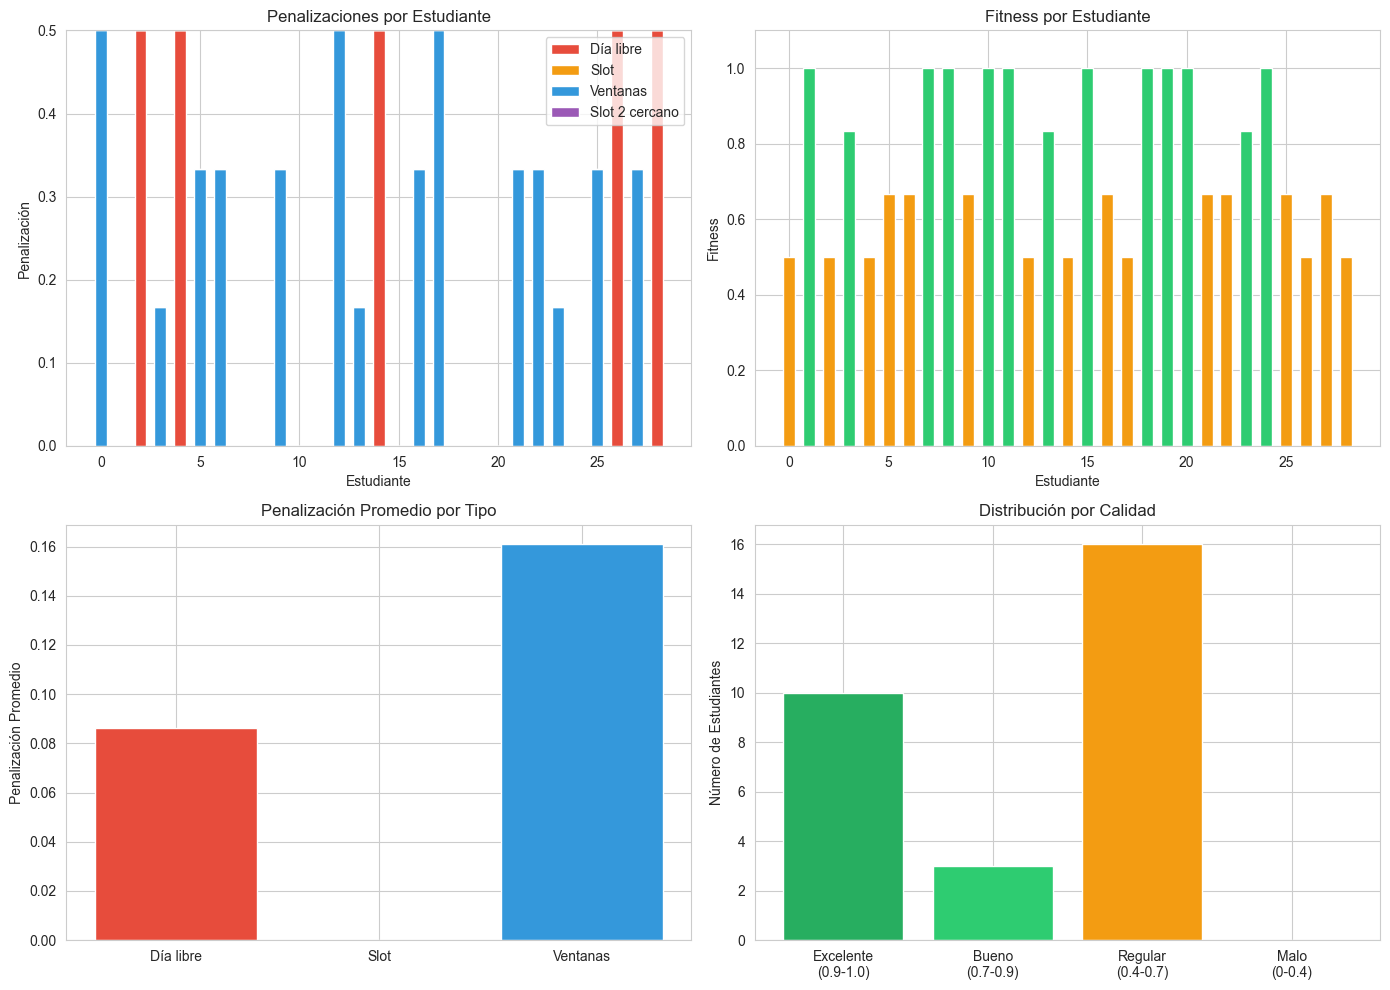

In [72]:
if len(df_attending) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    students = df_attending["student"].values
    p_free_day = df_attending["penalty_free_day"].values
    p_slot = df_attending["penalty_slot"].values
    p_windows = df_attending["penalty_windows"].values
    p_2 = df_attending["penalty_slot2"].values

    x = np.arange(len(students))
    width = 0.6

    # Barras apiladas
    axes[0, 0].bar(x, p_free_day, width, label="Día libre", color="#e74c3c")
    axes[0, 0].bar(x, p_slot, width, bottom=p_free_day, label="Slot", color="#f39c12")
    axes[0, 0].bar(
        x,
        p_windows,
        width,
        bottom=p_free_day + p_slot,
        label="Ventanas",
        color="#3498db",
    )
    axes[0, 0].bar(
        x,
        p_2,
        width,
        bottom=p_free_day + p_slot + p_windows,
        label="Slot 2 cercano",
        color="#9b59b6",
    )
    axes[0, 0].set_xlabel("Estudiante")
    axes[0, 0].set_ylabel("Penalización")
    axes[0, 0].set_title("Penalizaciones por Estudiante")
    axes[0, 0].legend()

    # Fitness
    fitness_values = df_attending["fitness"].values
    colors = [
        "#2ecc71" if f > 0.7 else "#f39c12" if f > 0.4 else "#e74c3c"
        for f in fitness_values
    ]
    axes[0, 1].bar(x, fitness_values, width, color=colors)
    axes[0, 1].set_xlabel("Estudiante")
    axes[0, 1].set_ylabel("Fitness")
    axes[0, 1].set_title("Fitness por Estudiante")
    axes[0, 1].set_ylim([0, 1.1])

    # Promedios
    penalty_types = ["Día libre", "Slot", "Ventanas"]
    penalty_means = [p_free_day.mean(), p_slot.mean(), p_windows.mean()]
    axes[1, 0].bar(
        penalty_types, penalty_means, color=["#e74c3c", "#f39c12", "#3498db"]
    )
    axes[1, 0].set_ylabel("Penalización Promedio")
    axes[1, 0].set_title("Penalización Promedio por Tipo")

    # Distribución
    ranges = [
        "Excelente\n(0.9-1.0)",
        "Bueno\n(0.7-0.9)",
        "Regular\n(0.4-0.7)",
        "Malo\n(0-0.4)",
    ]
    counts = [
        len(df_attending[df_attending["fitness"] >= 0.9]),
        len(
            df_attending[
                (df_attending["fitness"] >= 0.7) & (df_attending["fitness"] < 0.9)
            ]
        ),
        len(
            df_attending[
                (df_attending["fitness"] >= 0.4) & (df_attending["fitness"] < 0.7)
            ]
        ),
        len(df_attending[df_attending["fitness"] < 0.4]),
    ]
    axes[1, 1].bar(ranges, counts, color=["#27ae60", "#2ecc71", "#f39c12", "#e74c3c"])
    axes[1, 1].set_ylabel("Número de Estudiantes")
    axes[1, 1].set_title("Distribución por Calidad")

    plt.tight_layout()
    plt.show()

In [73]:
print("\n" + "=" * 80)
print("ANÁLISIS DE ESTUDIANTES CON FITNESS MALO")
print("=" * 80)

# Definir umbral de fitness malo (puedes ajustarlo)
BAD_FITNESS_THRESHOLD = 0.4

# Obtener estudiantes con fitness malo
df_metrics = sa_with_analysis["student_metrics"]
df_bad_fitness = df_metrics[
    (df_metrics["can_attend"]) & (df_metrics["fitness"] < BAD_FITNESS_THRESHOLD)
].sort_values("fitness")

print(f"\nUmbral de fitness malo: < {BAD_FITNESS_THRESHOLD}")
print(f"Estudiantes con fitness malo: {len(df_bad_fitness)}")

if len(df_bad_fitness) > 0:
    print("\nLista de estudiantes con fitness malo:")
    print("-" * 80)
    for idx, row in df_bad_fitness.iterrows():
        print(
            f"  Estudiante {int(row['student'])}: Fitness = {row['fitness']:.3f} "
            f"(Ayudante {int(row['assistant'])}, Slot {int(row['slot'])}, Día {int(row['day'])})"
        )
else:
    print("\n✅ ¡Excelente! No hay estudiantes con fitness malo.")


ANÁLISIS DE ESTUDIANTES CON FITNESS MALO

Umbral de fitness malo: < 0.4
Estudiantes con fitness malo: 0

✅ ¡Excelente! No hay estudiantes con fitness malo.


In [74]:
if len(df_bad_fitness) > 0:
    print("\n\n" + "=" * 80)
    print("HORARIOS DETALLADOS DE ESTUDIANTES CON FITNESS MALO")
    print("=" * 80)

    # Símbolos para la visualización
    SYMBOLS = {
        "class": "█",  # Clase del estudiante
        "assistantship": "🔴",  # Ayudantía asignada
        "free": "·",  # Bloque libre
    }

    # Nombres de días (ajusta según tu dataset)
    day_names = ["Lun", "Mar", "Mié", "Jue", "Vie"]

    for idx, row in df_bad_fitness.iterrows():
        student_id = int(row["student"])
        assigned_slot = int(row["slot"])
        assigned_day = int(row["day"])
        assistant_id = int(row["assistant"])

        print(f"\n{'=' * 80}")
        print(f"ESTUDIANTE {student_id}")
        print(f"{'=' * 80}")
        print(f"Fitness: {row['fitness']:.3f}")
        print(
            f"Ayudantía asignada: Ayudante {assistant_id} - Slot {assigned_slot}, Día {assigned_day}"
        )
        print("\nPenalizaciones:")
        print(f"  • Día libre: {row['penalty_free_day']:.3f}")
        print(f"  • Slot: {row['penalty_slot']:.3f}")
        print(f"  • Ventanas: {row['penalty_windows']:.3f}")
        print(f"  • Total: {row['penalty_total']:.3f}")
        print(f"  • Slot 2 cercano: {row['penalty_slot2']:.3f}")

        print("\nHorario semanal:")
        print("-" * 80)

        # Header con días
        header = "Slot |"
        for d in range(students_data.shape[1]):
            day_name = day_names[d] if d < len(day_names) else f"D{d}"
            header += f" {day_name:^5} |"
        print(header)
        print("-" * 80)

        # Mostrar cada slot
        for slot in range(students_data.shape[0]):
            row_str = f" {slot:2d}  |"

            for day in range(students_data.shape[1]):
                # Verificar si el estudiante tiene clase
                has_class = students_data[slot, day, student_id] == 1

                # Verificar si es el bloque de la ayudantía
                is_assistantship = slot == assigned_slot and day == assigned_day

                if is_assistantship:
                    cell = f" {SYMBOLS['assistantship']:^5} "
                elif has_class:
                    cell = f" {SYMBOLS['class']:^5} "
                else:
                    cell = f" {SYMBOLS['free']:^5} "

                row_str += f"{cell}|"

            print(row_str)

        print("-" * 80)
        print(
            f"Leyenda: {SYMBOLS['class']} = Clase | {SYMBOLS['assistantship']} = Ayudantía | {SYMBOLS['free']} = Libre"
        )

        # Análisis del horario
        print("\nAnálisis:")

        # Verificar si tiene clases ese día
        has_classes_that_day = any(
            students_data[s, assigned_day, student_id] == 1
            for s in range(students_data.shape[0])
        )
        if not has_classes_that_day:
            print(
                f"  ⚠️  El estudiante NO tiene clases el día {assigned_day} (penalización: 0.5)"
            )
        else:
            print(f"  ✓ El estudiante tiene clases el día {assigned_day}")

        # Verificar el slot - CÓDIGO CORREGIDO
        if assigned_slot in [0, 8, 9]:
            slot_desc = "muy temprano" if assigned_slot == 0 else "muy tarde"
            print(f"  ⚠️  Slot {assigned_slot} es {slot_desc} (penalización: 0.4)")
        elif assigned_slot == 7:
            print(
                f"  ⚠️  Slot {assigned_slot} es después de almuerzo (penalización: 0.3)"
            )
        else:
            print(f"  ✓ Slot {assigned_slot} es un horario bueno (sin penalización)")

        # Calcular ventanas
        if row["penalty_windows"] > 0:
            hours = row["penalty_windows"] * 6
            print(
                f"  ⚠️  Tiene ~{hours:.1f} hora(s) libre(s) entre clases (penalización: {row['penalty_windows']:.3f})"
            )
        else:
            print("  ✓ La ayudantía está pegada a sus clases")

        # Verificar slot 2 cercano
        if row["penalty_slot2"] > 0:
            print(
                f"  ⚠️  La ayudantía está en un slot adyacente a un bloque de clase (penalización: {row['penalty_slot2']:.3f})"
            )
        else:
            print("  ✓ No hay bloques de clase en slots adyacentes a la ayudantía")

else:
    print("\n✅ No hay estudiantes con fitness malo para mostrar horarios.")


✅ No hay estudiantes con fitness malo para mostrar horarios.
